In [222]:
import string
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import time

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, LabelBinarizer
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from scipy import interp
from itertools import cycle

#Visualization
import matplotlib as mpl
import matplotlib.pylab as pylab
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV


In [8]:
train = pd.read_csv('./Data/train_set.csv')
validation = pd.read_csv('./Data/validation_set.csv')
test = pd.read_csv('./Data/test_set.csv')

train = train.iloc[:10000, :]
validation = validation.iloc[:2000, :]
# train = pd.concat([train, validation])
train = train.dropna(axis = 0)
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=2000)
tweets = train['filtered_tweet'].dropna(axis = 0)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(tweets)

In [9]:
# training to tf-idf
x = tfidf_vectorizer_vectors
y = train['label'].astype('int')
x = x.astype('int')

# testing to tf-idf
tweets_test = test['filtered_tweet'].dropna(axis = 0)
tfidf_vectorizer_vectors_test = tfidf_vectorizer.fit_transform(tweets_test)
test_x = tfidf_vectorizer_vectors_test
test_y = test['label']



In [7]:
# calculate recall at specific k 
def recall_at_k(y_pred, y_true, k):
    ct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i][0:k]:
            ct += 1
    return ct/len(y_true)


In [79]:
cv_results = model_selection.cross_validate(alg, x, y, cv  = cv_split, scoring=['f1_macro','f1_micro'])
cv_results.keys()


dict_keys(['fit_time', 'score_time', 'test_f1_macro', 'test_f1_micro'])

In [10]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
     #Gaussian Processes
#     gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
##     naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
##     svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
#     discriminant_analysis.LinearDiscriminantAnalysis(),
#     discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
]
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0 )
MLA_columns = ['MLA Name', 'MLA Parameters','MLA F1 Macro','MLA F1 Micro','MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_predict = []
row_index = 0
for alg in MLA:
    
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, x, y, cv  = cv_split, scoring=['f1_macro','f1_micro'])

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA F1 Macro'] = cv_results['test_f1_macro'].mean()
    MLA_compare.loc[row_index, 'MLA F1 Micro'] = cv_results['test_f1_micro'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
#     MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
     #save MLA predictions - see section 6 for usage
    alg.fit(x, y)
    #MLA_predict[MLA_name] = alg.predict(x)
    MLA_predict.append(alg.predict(x))
    print('%s algorithm finishs predicting' % alg.__class__.__name__)
    row_index+=1
MLA_compare.sort_values(by = ['MLA F1 Micro'], ascending = False, inplace = True)
MLA_compare    

AdaBoostClassifier algorithm finishs predicting
BaggingClassifier algorithm finishs predicting
ExtraTreesClassifier algorithm finishs predicting
GradientBoostingClassifier algorithm finishs predicting
RandomForestClassifier algorithm finishs predicting
LogisticRegressionCV algorithm finishs predicting
PassiveAggressiveClassifier algorithm finishs predicting
RidgeClassifierCV algorithm finishs predicting
SGDClassifier algorithm finishs predicting
Perceptron algorithm finishs predicting
BernoulliNB algorithm finishs predicting
KNeighborsClassifier algorithm finishs predicting
SVC algorithm finishs predicting
LinearSVC algorithm finishs predicting
DecisionTreeClassifier algorithm finishs predicting
ExtraTreeClassifier algorithm finishs predicting
XGBClassifier algorithm finishs predicting


,MLA Name,MLA Parameters,MLA F1 Macro,MLA F1 Micro,MLA Time
16,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.128311,0.4412,12.8865
12,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.0380544,0.39945,15.5961
10,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.0385706,0.39935,0.00430427
13,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.0405007,0.39935,0.239394
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.0405007,0.39935,0.135596
15,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.0405007,0.39935,0.0149227
14,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.0405007,0.39935,0.0256711
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.0383922,0.3993,3.9057
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.0405121,0.39925,0.0692048
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.0407816,0.3992,0.174288


In [230]:
MLA[16]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
MLA_compare['MLA Parameters'][16]

"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}"

In [46]:
for alg in MLA:
    print(alg.__class__.__name__)

AdaBoostClassifier
BaggingClassifier
ExtraTreesClassifier
GradientBoostingClassifier
RandomForestClassifier
LogisticRegressionCV
PassiveAggressiveClassifier
RidgeClassifierCV
SGDClassifier
Perceptron
BernoulliNB
KNeighborsClassifier
SVC
LinearSVC
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier


In [59]:
recall_ft = pd.read_csv('recall_ft.csv')
# plt.plot(recall_ft['recall_ft'].values, label = 'fasttext')

## plot recall@k for best algorithms

Accuracy of XGBClassifier is: 0.39285
Accuracy of SVC is: 0.39737
Accuracy of BernoulliNB is: 0.09548
Accuracy of LinearSVC is: 0.33495
Accuracy of ExtraTreesClassifier is: 0.32557
Accuracy of DecisionTreeClassifier is: 0.36835


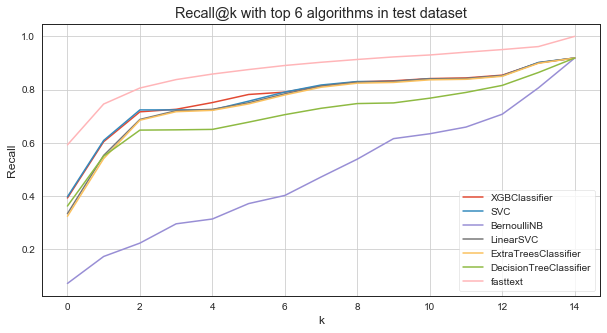

In [60]:
def plot_recallk(i: int, is_decision_func: bool, name: str):   
    ranks = []
    if is_decision_func:
        probs = MLA[i].decision_function(test_x)
    else:
        probs = MLA[i].predict_proba(test_x)
    for i in probs:
        ranks.append(np.argsort(i)[::-1])
    acc_rank = []
    for i in range(1, 16):
        acc_rank.append(recall_at_k(ranks, test_y, i))
    plt.plot(acc_rank, label = name)

plt.figure(figsize = (10,5))
# top 6 algorithms
best_mlas_index = [16,12,10,13,2,14]
proba = []
for i in best_mlas_index:
    name = MLA[i].__class__.__name__
    pred = MLA[i].predict(test_x)
    if 'SVC' in name or 'Passive' in name or 'Ridge' in name:
        plot_recallk(i, is_decision_func=True, name = name)
    else:
        plot_recallk(i, is_decision_func=False, name = name)
    acc = metrics.accuracy_score(test_y, pred)
    print('Accuracy of %s is: %.5f' % (MLA_compare['MLA Name'][i], acc))

#plot fasttext recall
plt.plot(recall_ft['recall_ft'].values, label = 'Fasttext')

plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall@k')
plt.legend(loc = 'lower right')
plt.grid()

## xgboost finding the parameters returning best score

In [231]:
# fit xgb with full training set
t = pd.read_csv('./Data/train_set.csv')
t = t.dropna()
tt = t['filtered_tweet'].dropna(axis = 0)
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=100)
tfidf_vectorizer_vectors_tt = tfidf_vectorizer.fit_transform(tt)
x_tt = tfidf_vectorizer_vectors_tt.astype('int')
y_tt = t['label'].astype('int')

start_tt = time.time()
model_tt = MLA[16].fit(x_tt, y_tt)
print(time.time() - start_tt)

tfidf_vectorizer_vectors_test = tfidf_vectorizer.fit_transform(tweets_test)
test_x = tfidf_vectorizer_vectors_test
test_y = test['label']
pred_tt = model_tt.predict(test_x)

43.94162893295288


In [233]:
# clf = CalibratedClassifierCV(MLA[13]) 
# clf.fit(x_tt, y_tt)
# proba_tt = clf.predict_proba(test_x)

probs_tt = model_tt.predict_proba(test_x)
ranks = []
for i in probs_tt:
    ranks.append(np.argsort(i)[::-1])
acc_rank = []
for i in range(1, 16):
    acc_rank.append(recall_at_k(ranks, test_y, i))
print(acc_rank)

[0.3991228070175439, 0.6178812415654521, 0.7140350877192982, 0.737719298245614, 0.7656545209176788, 0.7885290148448043, 0.7989203778677463, 0.8114035087719298, 0.8269905533063427, 0.8314439946018893, 0.8417004048582996, 0.8506747638326586, 0.8852226720647773, 0.9012145748987854, 0.9186234817813765]


0.060095977002532525
0.3997300944669366


<Figure size 576x288 with 0 Axes>

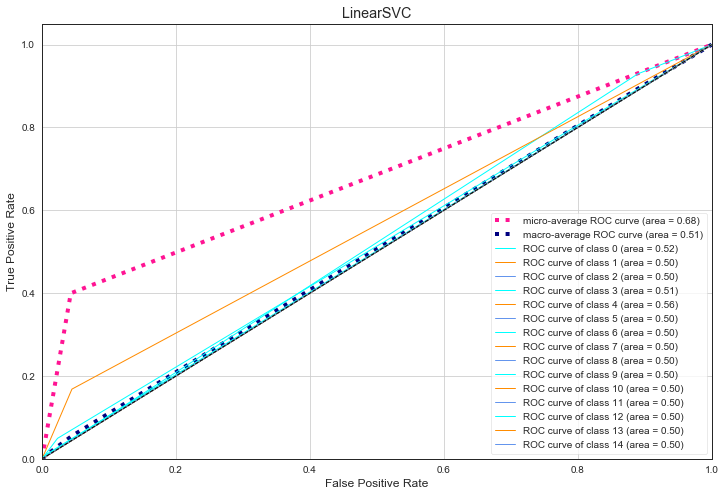

In [234]:
print(f1_score(test_y, pred_tt, average = 'macro'))
print(f1_score(test_y, pred_tt, average = 'micro'))
multiclass_AUC_plot(pred_tt, test_y, plot_name='LinearSVC')

In [105]:
# xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
#                           gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
#                           missing=None, n_jobs=-1, objective='multi:softmax', random_state=1, reg_alpha=0.0,
#                           reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# param_grid = { 
#     'colsample_bytree':[0.5,.75,1],
#     'learning_rate':[0.01,0.05,0.1,0.3,0.5],
#     'max_depth':[1,2,3,5,8,10],
#     'subsample':[.75,1],
#     'n_estimators': list(range(50, 400, 50))
# }
# grid_search = GridSearchCV(estimator=xgbcl, scoring='f1_micro', param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(x, y)

# print(f'Score: {grid_result.best_score_} using {grid_result.best_params_}','\n')

# #Set our final hyperparameters to the tuned values
# xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
#          gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
#          missing=None, n_jobs=-1, objective='multi:softmax', random_state=1, reg_alpha=0.0,
#          reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
#          colsample_bytree = grid_result.best_params_['colsample_bytree'], 
#          learning_rate = grid_result.best_params_['learning_rate'], 
#          max_depth = grid_result.best_params_['max_depth'], 
#          subsample = grid_result.best_params_['subsample'], 
#          n_estimators = grid_result.best_params_['n_estimators'])

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# #refit the model on k-folds to get stable avg error metrics
# scores = cross_validate(estimator=xgbcl, X=x, y=y, cv=kfold, n_jobs=-1, 
#                         scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

# print('Training 5-fold Cross Validation Results:\n')
# print('AUC: ', scores['test_roc_auc'].mean())
# print('Accuracy: ', scores['test_accuracy'].mean())
# print('Precision: ', scores['test_precision'].mean())
# print('Recall: ', scores['test_recall'].mean())
# print('F1: ', scores['test_f1'].mean(), '\n')

In [92]:
def cm_ht_cr(y_true, y_pred):
    target_names = ['0', '1', '2', '3', '4', '5', '7',
                '8', '11', '13', '14', '15', '16', '17', '19']
    x_axis_labels = target_names
    y_axis_labels = target_names
    cm_lstm = confusion_matrix(y_true, y_pred)
    
    # heatmap
    plt.figure(figsize=(10,8))
    hm_lstm = sns.heatmap(cm_lstm, linewidths = 0.5, vmax = 100, annot = True, fmt = 'd', \
                          xticklabels=x_axis_labels, yticklabels= y_axis_labels)
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names = target_names))

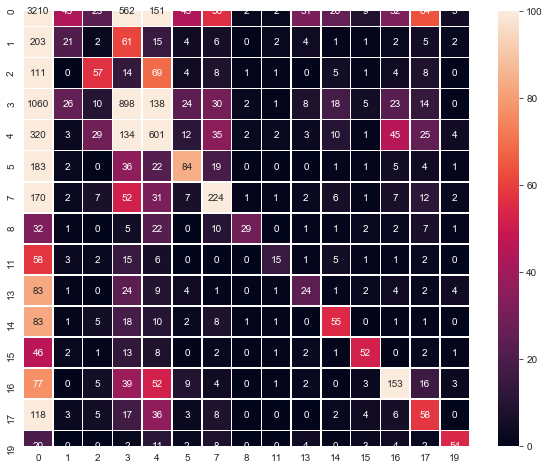

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      4259
           1       0.19      0.06      0.10       329
           2       0.39      0.20      0.27       283
           3       0.48      0.40      0.43      2257
           4       0.51      0.49      0.50      1226
           5       0.42      0.23      0.30       358
           7       0.53      0.43      0.47       525
           8       0.76      0.26      0.38       113
          11       0.54      0.14      0.22       109
          13       0.29      0.15      0.20       160
          14       0.42      0.30      0.35       186
          15       0.60      0.40      0.48       131
          16       0.53      0.42      0.47       364
          17       0.26      0.22      0.24       260
          19       0.70      0.49      0.58       110

    accuracy                           0.52     10670
   macro avg       0.48      0.33      0.37     10670
weighted avg       0.50   

In [97]:
# heatmap, f1, recall, precision by bi-lstm
bi_lstm = pd.read_csv('bi_lstm_preds.csv')
y_true, y_pred = bi_lstm['y_true'], bi_lstm['y_pred']
cm_ht_cr(y_true, y_pred)

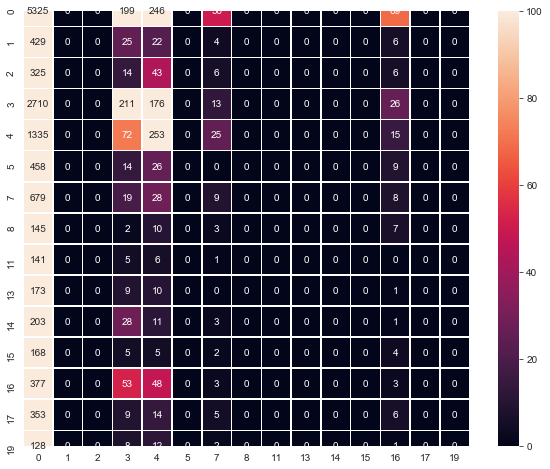

              precision    recall  f1-score   support

           0       0.41      0.90      0.57      5889
           1       0.00      0.00      0.00       486
           2       0.00      0.00      0.00       394
           3       0.31      0.07      0.11      3136
           4       0.28      0.15      0.19      1700
           5       0.00      0.00      0.00       507
           7       0.07      0.01      0.02       743
           8       0.00      0.00      0.00       167
          11       0.00      0.00      0.00       153
          13       0.00      0.00      0.00       193
          14       0.00      0.00      0.00       246
          15       0.00      0.00      0.00       184
          16       0.02      0.01      0.01       484
          17       0.00      0.00      0.00       387
          19       0.00      0.00      0.00       151

    accuracy                           0.39     14820
   macro avg       0.07      0.08      0.06     14820
weighted avg       0.27   

In [201]:
# heatmap, f1, recall, precision by xgboost
pred_xgb = MLA[14].predict(test_x)
cm_ht_cr(test_y, pred_xgb)

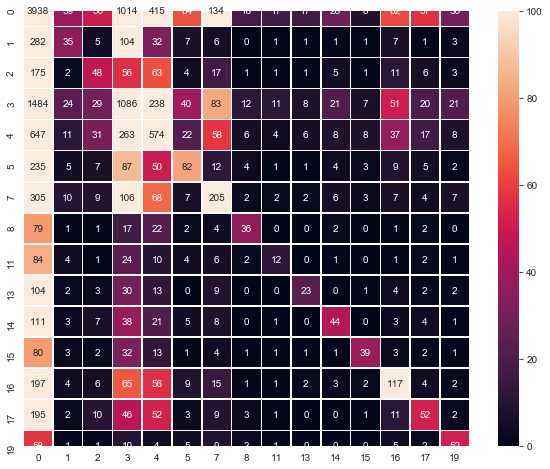

              precision    recall  f1-score   support

           0       0.49      0.67      0.57      5891
           1       0.24      0.07      0.11       486
           2       0.23      0.12      0.16       394
           3       0.36      0.35      0.36      3135
           4       0.35      0.34      0.34      1700
           5       0.32      0.16      0.22       507
           7       0.35      0.28      0.31       743
           8       0.40      0.22      0.28       167
          11       0.22      0.08      0.12       152
          13       0.37      0.12      0.18       193
          14       0.35      0.18      0.24       246
          15       0.53      0.21      0.30       184
          16       0.36      0.24      0.29       484
          17       0.29      0.13      0.18       387
          19       0.39      0.34      0.36       151

    accuracy                           0.43     14820
   macro avg       0.35      0.23      0.27     14820
weighted avg       0.40   

In [144]:
fasttext_df = pd.read_csv('fastttext_preds.csv')
y_pred_ft = fasttext_df['y_pred']
y_true_ft = fasttext_df['y_true']
cm_ht_cr(y_true_ft, y_pred_ft)

In [172]:
# ============= Useful Function ========================
def multiclass_AUC_plot(y_pred, y_true, plot_name, classes = [0, 1, 2, 3, 4, 5, 7, 8, 11, 13, 14, 15, 16, 17, 19]):
    '''
    Plot for AUC curves
    :param y_true:
    :param y_pred:
    :param classes:
    :return:
    '''
    plt.figure(figsize=(8,4))
    y_true = label_binarize(y_true, classes)
    y_pred = label_binarize(y_pred, classes)

    n_classes = len(classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure()
    lw = 1
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_name)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
#     plt.savefig(plot_name,  dpi=600)
    
    

<Figure size 576x288 with 0 Axes>

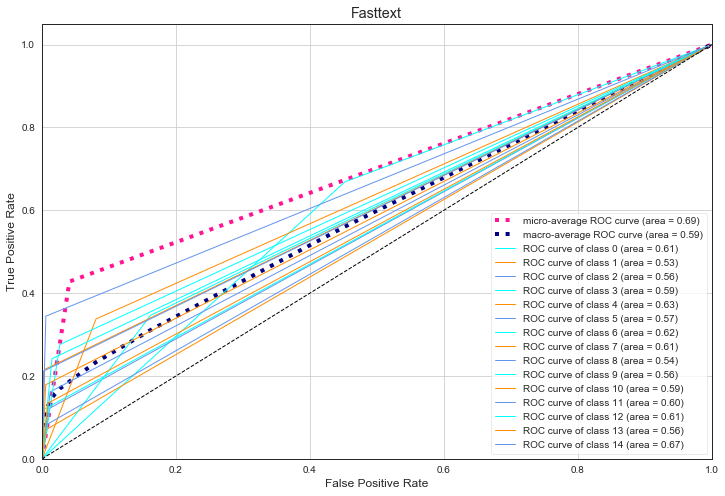

In [173]:
multiclass_AUC_plot(y_pred_ft, y_true_ft, plot_name='Fasttext')

<Figure size 576x288 with 0 Axes>

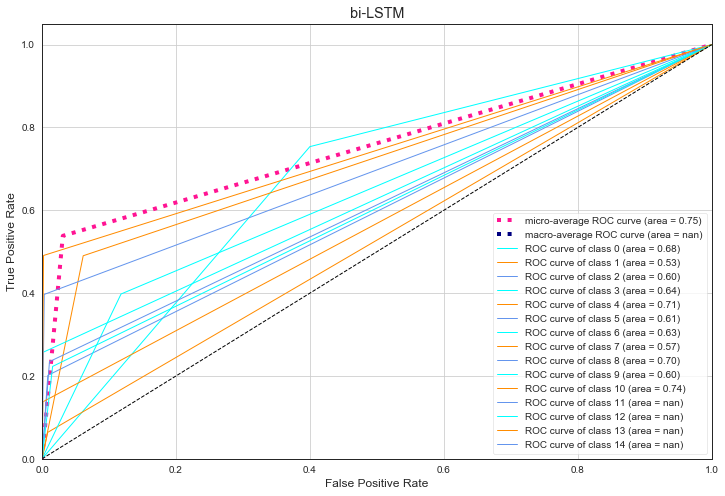

In [175]:
multiclass_AUC_plot(y_pred, y_true, plot_name='bi-LSTM')

In [226]:
def prob_ranking(input_path):
    test_df = pd.read_csv(input_path, header=0)
    X = test_df.dropna(subset=['filtered_tweet'])

    x_test = X['filtered_tweet'].tolist()
    y_test = X['label']
    
    ground_truth = np.array(y_test)
    predictions = np.zeros(shape=(X.shape[0],15))
    
    for i in range(len(x_test)):
        y_pred_dict = {}
        y_pred = emft.getModel().predict(x_test[i], k=15)
        
        for j in range(len(y_pred[0])):
            y_pred_dict[int(y_pred[0][j][9:])]= float(y_pred[1][j])
        
        y_pred_pairs = sorted(y_pred_dict.items())   

        score = []
        for pair in y_pred_pairs:
            score.append(pair[1])      
        
        predictions[i] = score
    
    return ground_truth, predictions

    
ground_truth, predictions = prob_ranking(input_path='./Data/test_set.csv')

def dcg_score(y_true, y_score, k=3):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=3):
    
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
#         print(actual)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# ndcg_score(ground_truth, predictions, k=5)

In [237]:
ndcg_score(test_y, probs_tt)

0.5852209352954566

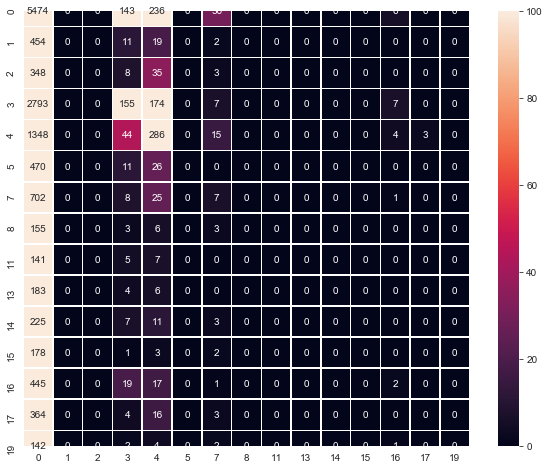

              precision    recall  f1-score   support

           0       0.41      0.93      0.57      5889
           1       0.00      0.00      0.00       486
           2       0.00      0.00      0.00       394
           3       0.36      0.05      0.09      3136
           4       0.33      0.17      0.22      1700
           5       0.00      0.00      0.00       507
           7       0.09      0.01      0.02       743
           8       0.00      0.00      0.00       167
          11       0.00      0.00      0.00       153
          13       0.00      0.00      0.00       193
          14       0.00      0.00      0.00       246
          15       0.00      0.00      0.00       184
          16       0.10      0.00      0.01       484
          17       0.00      0.00      0.00       387
          19       0.00      0.00      0.00       151

    accuracy                           0.40     14820
   macro avg       0.09      0.08      0.06     14820
weighted avg       0.28   

In [238]:
cm_ht_cr(test_y, pred_tt)